# 神经网络回归-添加权重、正则项
- 参考 CSDN 第六周作业
- deepFM / 加上权重初始化 / 添加正则项

In [1]:
# 导入必要的工具包
import time
import numpy as np 
import pandas as pd 
import tensorflow as tf

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
Y_Standard = True
# 生成的结果文件编号
out_name = '%ssummit=0.1-fe-%s.csv'

# path  = '../data/new/'
path_train = '../data/new/train=0.1/'
path_test = '../data/new/test/'
summit_path = '../data/summit/'

## 1 数据准备

In [3]:
train = pd.read_csv(path_train + 'train=0.1-fe.csv')
train.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price
0,2320186,124,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.833333,0.0,0,0.0
1,2959017,121,129429,78242,0,0,6000,0,152480,48626,...,0,0,0,2,2,2,3.166667,0.0,0,0.0
2,242613,122,84839,52467,0,0,0,0,22144,29600,...,0,0,0,0,0,0,2.666667,0.0,0,0.0
3,1416097,136,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
4,680469,104,28625,7200,0,0,0,0,33625,3930,...,0,0,0,0,0,0,1.000000,0.0,0,0.0


In [4]:
test = pd.read_csv(path_test + 'tap_fun_test-fe.csv')
test.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,sr_rss_help_bonus_level,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count
0,14933,94,166415.0,138362.0,0,0,0,0,258522,90142,...,0,0,0,0,1,1,1,8.000000,0.0,0
1,14934,94,10000.0,600.0,0,0,0,0,10000,400,...,0,0,0,0,0,0,0,0.166667,0.0,0
2,14935,94,10000.0,3700.0,0,0,0,0,10000,2000,...,0,0,0,0,0,0,0,17.000000,0.0,0
3,14936,94,210000.0,0.0,200000,0,200000,0,610000,0,...,0,0,0,0,0,0,0,1.666667,0.0,0
4,14937,94,11500.0,3700.0,0,0,0,0,11000,2000,...,0,0,0,0,0,0,0,0.333333,0.0,0


In [5]:
# 从原始数据中分离输入特征x和输出y
target = 'prediction_pay_price'
id = 'user_id'
train_y = train[target].values
train_X = train.drop([target, id], axis = 1)

# test_id = test[id]
test_X = test.drop([id], axis = 1)

In [6]:
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(train_X, train_y, random_state=33, test_size=0.1)
print('train.shape=%s X_train_part.shape=%s X_test_part.shape=%s'
      %(train.shape, X_train_part.shape, X_val_part.shape))

train.shape=(228800, 109) X_train_part.shape=(205920, 107) X_test_part.shape=(22880, 107)


## 2 数据标准化

In [7]:
# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
X_train_part = ss_X.fit_transform(X_train_part)
X_val_part = ss_X.transform(X_val_part)
test_X = ss_X.transform(test_X)

if Y_Standard:
    y_train_part = ss_y.fit_transform(y_train_part.reshape(-1, 1))
    y_val_part = ss_y.transform(y_val_part.reshape(-1, 1))

In [8]:
# 标准化数据还原 
def inverse_StandardScaler(predict):
    if Y_Standard:
        predict = ss_y.inverse_transform(predict)
        print('predict = ', predict)
    return predict

#输出预测后的数据
def generate_summit(predict):
    testPredict = test.copy()
    testPredict[target] = predict
    testPredict = testPredict[[id,target]]
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

## 3. 训练模型

In [9]:
def add_layer(inputs, in_size, out_size, activation_function=None):
    '''添加层，返回本层的输出项
    in_size 输入节点个数
    out_size 输出节点个数
    '''
    #在ReLU 激活函数中推荐使用 Xavier 初始化的变种，暂且称之为 He Initialization：
    Weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.5)) / np.sqrt(in_size / 2)
    
    #计算正则项，加入集合losses里面
#     reg = tf.contrib.layers.l1_regularizer(0.0001)(Weights)
    reg = tf.contrib.layers.l1_regularizer(0.01)(Weights)
#     reg = tf.contrib.layers.l1_regularizer(0.1)(Weights)
    tf.add_to_collection("losses", reg)
    
    # 偏置初始化分布参数设置  
    biases = tf.Variable(tf.constant(0.1, shape=[out_size]))
    
    Wx_plus_b = tf.matmul(inputs, Weights) + biases
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    return outputs

In [10]:
# 定义网络结构
n_input = X_train_part.shape[1]
n_output = y_train_part.shape[1]
tf_x = tf.placeholder(tf.float32, [None,n_input])     # input x
tf_y = tf.placeholder(tf.float32, [None,n_output])     # input y

# 神经元数量=数据维度 ,添加隐层，调整神经元个数，看看效果 
# layer_dim = [n_input, 107, n_output]
# layer_dim = [n_input, 107, 50, n_output]
# layer_dim = [n_input, 107, 50, 20, n_output]
layer_dim = [n_input, 55, 27, n_output]
n_layers = len(layer_dim) #神经网络的层数

output_layer = tf_x
in_dimension = layer_dim[0]
for i in range (1, n_layers):
    out_dimension = layer_dim[i]
    if out_dimension == n_output:
        active_fun = None 
    else: #调整激活函数
#         active_fun = tf.nn.relu6
        active_fun = tf.nn.relu
    
    # 添加层：有 out_dimension 个神经元 
    output_layer = add_layer(output_layer, in_dimension, out_dimension, activation_function=active_fun)
    in_dimension = layer_dim[i]
#     cur_layer = tf.layers.batch_normalization(cur_layer) #加快收敛
#     cur_layer = tf.layers.dropout(cur_layer, rate=0.5) #防止过拟合

loss = tf.losses.mean_squared_error(tf_y, output_layer)   # compute cost 损失函数 
tf.add_to_collection("losses", loss)#把交叉熵损失，也加入到集合里

# 调整优化器和学习率 
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

In [11]:
def model_validation(epoch):
    ''' 模型校验 '''
#     train_loss = sess.run(loss, {tf_x: X_train_part, 
#                                     tf_y: y_train_part})
    val_loss = sess.run(loss, {tf_x: X_val_part, 
                                    tf_y: y_val_part})
    if epoch % 1 == 0:
        print('---------------- epoch=%s  val_loss=%s' % (epoch+1, val_loss))
    
    return val_loss

In [12]:
# 训练参数
n_sample = X_train_part.shape[0]
# batch_size = int(n_sample / 2)
batch_size = 20592
n_step = int(np.ceil(n_sample / batch_size))
n_epoch = 40
early_stopping_max = 10
early_stopping_threshold = 0.3
print('n_sample=%s batch_size=%s n_step=%s n_epoch=%s' % (n_sample, batch_size, n_step, n_epoch))

n_sample=205920 batch_size=20592 n_step=10 n_epoch=40


In [13]:
# 进行训练
sess = tf.Session()
sess.run(tf.global_variables_initializer())         # initialize var in graph
loss_train_arr = []
loss_val_arr = []
time_count = []
# losses = []
early_stopping_n = 0

for epoch in range(n_epoch):
    ticks = time.time()
#     print('=============== epoch=%s' % (epoch+1))
    for step in range(n_step):
        # train and net output
        i_from = step * batch_size
        i_to = (step+1) * batch_size
        if i_to > (n_sample - 1): #索引越界处理 
            i_to = (n_sample - 1)
        _, loss_v, pred = sess.run([train_op, loss, output_layer], {tf_x: X_train_part[i_from:i_to], 
                                                         tf_y: y_train_part[i_from:i_to]})
#         losses.append(loss_v)
#         if step % 5 == 0:
#             print('step=%s loss=%s' % (step+1, loss_v))
    mean_loss = loss_v # np.mean(losses)
    loss_train_arr.append(mean_loss)
    val_loss = model_validation(epoch)
    loss_val_arr.append(val_loss)
    ticks = np.round((time.time() - ticks) * 100) / 100
    time_count.append(ticks)
    if epoch % 1 == 0:
        print('%ss/epoch  loss=%s' % (ticks, mean_loss))
    if val_loss < early_stopping_threshold:
        early_stopping_n += 1
    if early_stopping_n > 10:
        break

time_total = np.sum(time_count)
print('time_total=%ss time_epoch=%s'%(time_total, time_count[0]))

---------------- epoch=1  val_loss=2.0447962
0.42s/epoch  loss=0.21091798
---------------- epoch=2  val_loss=1.9040078
0.39s/epoch  loss=0.19448122
---------------- epoch=3  val_loss=1.7762073
0.39s/epoch  loss=0.18179508
---------------- epoch=4  val_loss=1.6603175
0.4s/epoch  loss=0.17088756
---------------- epoch=5  val_loss=1.5462295
0.46s/epoch  loss=0.15968198
---------------- epoch=6  val_loss=1.4265516
0.45s/epoch  loss=0.14805004
---------------- epoch=7  val_loss=1.3054146
0.45s/epoch  loss=0.13579997
---------------- epoch=8  val_loss=1.1780583
0.44s/epoch  loss=0.12388119
---------------- epoch=9  val_loss=1.0484067
0.45s/epoch  loss=0.1125635
---------------- epoch=10  val_loss=0.9126417
0.4s/epoch  loss=0.10251613
---------------- epoch=11  val_loss=0.789139
0.39s/epoch  loss=0.09407146
---------------- epoch=12  val_loss=0.68199235
0.39s/epoch  loss=0.087689385
---------------- epoch=13  val_loss=0.59379107
0.39s/epoch  loss=0.083230376
---------------- epoch=14  val_los

## 4. 训练结果可视化

In [14]:
# 训练次数，x 轴
# x = np.arange(0, n_epoch, 1)
x = np.arange(0, len(loss_val_arr), 1)

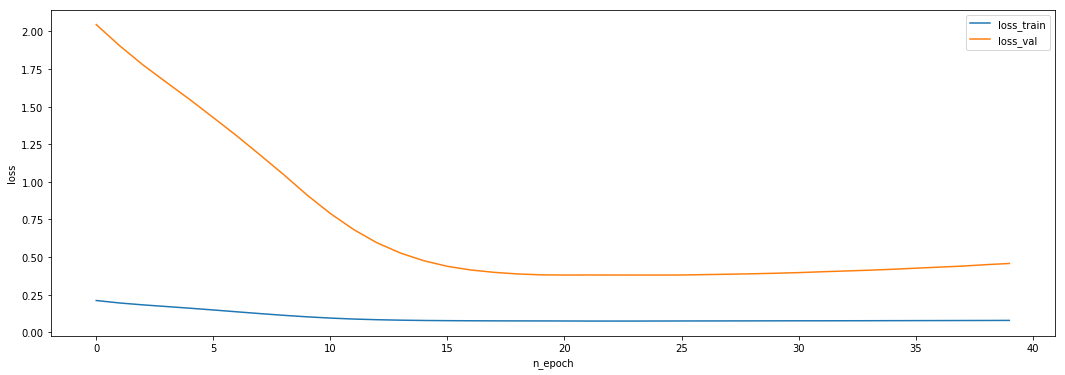

In [15]:
plt.figure(figsize=(18, 6))
# plt.plot(x, loss_train_arr, '-o', label='loss_train')
plt.plot(x, loss_train_arr, '-', label='loss_train')
plt.plot(x, loss_val_arr, '-', label='loss_val')

plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 5. 模型应用

In [16]:
#对测试数据进行预测
test_pred = sess.run(output_layer, {tf_x:test_X})
print('test_pred = ', test_pred)

# 标准化数据还原 
test_pred = inverse_StandardScaler(test_pred)

test_pred =  [[-0.01148982]
 [-0.01328249]
 [-0.00457078]
 ...
 [-0.08237348]
 [-0.02355857]
 [-0.02021329]]
predict =  [[ 0.838976  ]
 [ 0.7253755 ]
 [ 1.2774317 ]
 ...
 [-3.6528862 ]
 [ 0.07418507]
 [ 0.28617376]]


In [17]:
#输出预测后的数据
testPredict = generate_summit(test_pred)
testPredict.to_csv(out_name %(summit_path, 'DNN_V2'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.838976
1,14934,0.725375
2,14935,1.277432
3,14936,0.691077
4,14937,0.897122


In [18]:
# # 最后要关闭 
# sess.close()